In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

# important to read data from .parquet 
from pyarrow import parquet

tqdm.pandas()
%matplotlib inline

In [4]:
# To skip unwanted code
skip = True
shopper_50 = '_50'

def timer(start):
    # from time import time
    return round(time() - start)

### Read data and save original count of rows and columns

In [5]:
try:
    df = pd.read_parquet(f'data/basket_discount{shopper_50}.parquet')
    print("DF is read")
    # Check for not exporting basket_discount again
    df_is_exported = True
except FileNotFoundError as e:
    print(e)
    print(f"Start reading files")
    print("READING....")
    baskets = pd.read_parquet('data/baskets.parquet')
    coupons = pd.read_parquet('data/coupons.parquet')
    coupon_index = pd.read_parquet('data/coupon_index.parquet')
    print(f"Files are read")
    df_is_exported = False

DF is read


### Merging baskets and coupons to a new df 

In [6]:
if df_is_exported==False:
    print(f"Start Mergin baskets and coupons")
    print(f"MERGING....")
    df = pd.merge(
        baskets,
        coupons,
        how='outer',
        on=['week','shopper', 'product']
    )
    print("Done")
    print(f"Merge took: {timer(start)}")
    del baskets
    del coupons

# Tried JOIN / MERGE using indexes = ERROR
# NEED to try join on index + other columns
# JOIN = 230.641s (1-run)
# MERGE = 156s (1-run)

In [7]:
if shopper_50 != '':
    print('shopper_50 variable is set')
    df = df[df['shopper'] < 50 ]

shopper_50 variable is set


### Clean Data Frame by replacing NaN to 0s in the price column then remove rows with NaN

In [8]:
if df_is_exported==False:
    df['price'] = df['price'].astype(int)
    df['discount'] = df['discount'].astype(int)
    df['price'].fillna(0, inplace=True)
    df['discount'].fillna(0, inplace=True)

    assert df[ ( df['shopper'] == 0 ) & ( df['week'].isin([0,88]) )]['price'].sum() == 10565 # manuelly computed
    assert df.isna().sum().sum() == 0

### Export processed data for later import instead of repeating all previous steps

In [9]:
if df_is_exported==False:
    df.to_parquet(f'data/basket_discount{shopper_50}.parquet', index=False)

In [10]:
print(
    f"Number of Rows in Data: {df.shape[0]:,}\n",
    f"Numer of Shoppers: { len(df['shopper'].unique()):,}\n",
    f"Numer of Products: { len(df['product'].unique()):,}\n",
    f"Numer of Weeks: { len(df['week'].unique()):,}\n"
)

Number of Rows in Data: 55,714
 Numer of Shoppers: 50
 Numer of Products: 250
 Numer of Weeks: 90



## What each shopper ordered count basket items, total basket, what products 

In [11]:
# Each week order for each shopper and what items contained in the order

# Helper Functions
def combine_list(x):
    return list(set(x))
def ones(x):
    return int(1)

try:
    basket_week = pd.read_parquet(f'data/basket_week{shopper_50}.parquet')
except FileNotFoundError:
    start = time()
    basket_week = \
        df \
        .groupby(['week', 'shopper'], as_index=False) \
        .agg({
            'price': ['sum'],
            'discount': 'sum',
            'product': combine_list
            })
    basket_week.columns = [('_'.join(x)).rstrip('_') for x in basket_week.columns]
    basket_week.rename(columns={'product_combine_list':'basket'}, inplace=True)
    basket_week.columns = [x.replace('_sum','') for x in basket_week.columns]

    basket_week['count'] = basket_week['basket'].apply(len)
    # basket_week.set_index(['week', 'shopper'], inplace=True)
    print(f"basket_week took: {timer(start)}")


    basket_week.to_parquet(f'data/basket_week{shopper_50}.parquet')

basket_week.head()

,week,shopper,price,discount,basket,count
0,0,0,5908,170,"[225, 193, 35, 5, 71, 167, 27, 91, 171, 207, 1...",15
1,0,1,4648,135,"[35, 99, 229, 101, 7, 168, 200, 146, 211, 115,...",13
2,0,2,3697,115,"[185, 164, 249, 230, 38, 14, 18, 23, 56, 121, ...",11
3,0,3,4082,100,"[192, 98, 67, 229, 6, 137, 203, 109, 145, 122,...",12
4,0,4,2680,130,"[131, 234, 76, 144, 156, 212, 248, 25, 188, 127]",10


# Linear Model for Basket total

In [12]:
# Group data to get basket total for each shopper per week

## Training functions
# Function to get weeks to train the model then
def get_shopper_data(df, shopper, start_week, end_week):
    filt = (df['shopper'] == shopper) & (df['week'].isin(range(start_week,end_week+1)))
    return df.loc[filt, ['week', 'count', 'price']]

# Get a week coef, intercept, pred for basket total
def pred_basket_total(ln_object, df, pred_week, pred_shopper, basket_count):
    ln_object.fit(df[['week', 'count']],df[['price']])
    pred = ln_object.predict([[pred_week, pred_shopper, basket_count]])
    return ln_object.coef_.flatten(), ln_object.intercept_.flatten(), pred.flatten()

# Get a week coef, intercept, pred for basket count
def pred_basket_count(reg, df, pred_week):
    reg.fit(df[['week']],df[['count']])
    pred = reg.predict([[pred_week]])
    return np.floor(pred.flatten())


## Testing functions

In [13]:
# reg = linear_model.LinearRegression()
reg = linear_model.Lasso()
# reg = linear_model.LassoCV() # Slow as LightGBM
# reg = linear_model.LogisticRegression()
# scaler = preprocessing.StandardScaler(with_std=True)

window = 2
shoppers_range = range(0,10)
basket_count_mse = dict()

for ln_shopper in tqdm(shoppers_range): # EDIT start and end shopper

    test_pred = dict()

    for tw in range(60,90,window): # EDIT start and end week
        train = get_shopper_data(basket_week, ln_shopper, int(0+(tw%10-5)), tw-1)
        test_pred[tw] = pred_basket_count(reg, train, tw)

    test_pred = pd.DataFrame(test_pred, index= ['pred']).T

    c1 = test_pred.index.min()
    c2 = test_pred.index.max()
    validate_pred = get_shopper_data(basket_week, ln_shopper, c1, c2)
    validate_pred = validate_pred \
        .merge(test_pred, how='left',left_on=['week'], right_index=True) \
        .fillna(method='ffill')


    mse = np.round(metrics.mean_squared_log_error(validate_pred['count'], validate_pred['pred']),2)
    basket_count_mse[ln_shopper] = [mse, 1-mse]

basket_count_mse = pd.DataFrame(basket_count_mse, index=['mse', 'accuracy']).T


basket_count_mse

100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


,mse,accuracy
0,0.02,0.98
1,0.03,0.97
2,0.05,0.95
3,0.03,0.97
4,0.02,0.98
5,0.03,0.97
6,0.04,0.96
7,0.03,0.97
8,0.02,0.98
9,0.03,0.97


# LightGBM Model

## LightGBM is too slow and LN is more accurate

In [14]:
# LightGBM
# !pip install lightgbm

import lightgbm as lgb

clf = lgb.LGBMClassifier(
    # options to increase accurecy but no effect
    # num_leaves=30,
    # max_depth=5,
    # learning_rate=0.1,
    # n_estimators=50,
    # max_bin=225,
    # min_child_samples=10
)
# clf = lgb.LGBMRegressor()


window = 2
shoppers_range = range(0,10)
basket_count_mse = dict()

for ln_shopper in tqdm(shoppers_range): # EDIT start and end shopper

    test_pred = dict()

    for tw in range(60,90,window): # EDIT start and end week
        train = get_shopper_data(basket_week, ln_shopper, int(0+(tw%10-5)), tw-1)
        test_pred[tw] = pred_basket_count(clf, train, tw)

    test_pred = pd.DataFrame(test_pred, index= ['pred']).T

    c1 = test_pred.index.min()
    c2 = test_pred.index.max()
    validate_pred = get_shopper_data(basket_week, ln_shopper, c1, c2)
    validate_pred = validate_pred \
        .merge(test_pred, how='left',left_on=['week'], right_index=True) \
        .fillna(method='ffill')

    mse = np.round(metrics.mean_squared_log_error(validate_pred['count'], validate_pred['pred']),2)
    basket_count_mse[ln_shopper] = [mse, 1-mse]

basket_count_mse = pd.DataFrame(basket_count_mse, index=['mse', 'accuracy']).T


basket_count_mse

100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


,mse,accuracy
0,0.04,0.96
1,0.03,0.97
2,0.13,0.87
3,0.06,0.94
4,0.02,0.98
5,0.06,0.94
6,0.06,0.94
7,0.04,0.96
8,0.04,0.96
9,0.04,0.96


In [15]:
# How much each discount can converge to sales

discount_freq = df.groupby(['week','shopper', 'discount'], as_index=False).agg({'price':sum, })

discount_freq_filter = (discount_freq['discount'] <= 30) & (discount_freq['discount'] >= 15)
discount_freq = discount_freq.loc[discount_freq_filter]

discount_freq.rename(columns={'price':'w_discount'}, inplace=True)
discount_freq = pd.merge(discount_freq, basket_week[['week', 'shopper', 'price']], on=['week','shopper'])
discount_freq.rename(columns={'price':'total_basket'}, inplace=True)

discount_freq['conv'] = np.round((discount_freq['w_discount'] / discount_freq['total_basket']),2)
discount_freq.drop(['w_discount', 'total_basket'], inplace=True, axis=1)

discount_freq.loc[discount_freq['shopper'] == 0].head()

,week,shopper,discount,conv
0,0,0,30,0.00
112,1,0,15,0.00
113,1,0,25,0.00
223,2,0,15,0.00
224,2,0,25,0.09


In [16]:
# How much purchases with each discount and what items are being purchased

try:
    discount_basket = pd.read_parquet(f'data/discount_basket{shopper_50}.parquet')
except FileNotFoundError:
    start = time()
    discount_basket = \
        df.loc[(df['discount'] <= 30) & (df['discount'] >= 15)] \
        .groupby(['week', 'shopper', 'discount'], as_index=False) \
        .agg({
            'price': 'sum',
            'product': combine_list
            })
    discount_basket.rename(columns={'price':'total', 'product':'basket'}, inplace=True)    
    discount_basket = pd.merge(discount_basket, basket_week[['week', 'shopper', 'price']], on=['week','shopper'])
    discount_basket.rename(columns={'price':'total_basket'}, inplace=True)
    discount_basket['conv'] = np.round((discount_basket['total'] / discount_basket['total_basket']),2)
    discount_basket.drop(['total', 'total_basket'], inplace=True, axis=1)

    discount_basket['count'] = discount_basket['basket'].apply(len)
    print(f"discount_basket took: {timer(start)}")


    discount_basket.to_parquet(f'data/discount_basket{shopper_50}.parquet')

discount_basket.head()

,week,shopper,discount,basket,conv,count
0,0,0,30,"[27, 5]",0.0,2
1,0,1,15,[7],0.0,1
2,0,1,25,[18],0.0,1
3,0,1,30,"[115, 101]",0.0,2
4,0,2,30,"[38, 23]",0.0,2


In [17]:
# each shopper how many orders are placed and which weeks

try:
    orders_shopper = pd.read_parquet(f'data/orders_shopper{shopper_50}.parquet')
except FileNotFoundError:
    start = time()
    orders_shopper = \
        df.loc[df['price'] != 0] \
        .groupby(['shopper'], as_index=False) \
        .agg({'week': combine_list})

    orders_shopper['count'] = orders_shopper['week'].apply(len)
    # orders_shopper.set_index(['shopper'], inplace=True)
    
    print(f"orders_shopper took: {timer(start)}")

    orders_shopper.to_parquet(f'data/orders_shopper{shopper_50}.parquet')

orders_shopper.head()

,shopper,week,count
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",90


## ITEM SHOPPER interaction heat map

In [18]:
# map showing if shopper bought an item in his history

try:
    shopper_product = pd.read_parquet(f'data/shopper_product{shopper_50}ss.parquet')
except FileNotFoundError:
    start = time()
    shopper_product = df.loc[df['price'] != 0] \
        .groupby(['shopper', 'product'], as_index=False) \
        .agg({'price': sum})

    shopper_product['price'] = np.where(shopper_product['price'] > 0, 1, 0)

    print(f"shopper_product took: {timer(start)}")

    # shopper_product.to_parquet(f'data/shopper_product{shopper_50}.parquet')

    # to pivot the data and make shopper as rows and weeks as columns
    shopper_product = shopper_product.pivot(index='shopper', columns='product', values='price')
    print(type(shopper_product))
    # shopper_product = shopper_product.apply(lambda x: 0 if x == np.nan else x )

shopper_product

shopper_product took: 0
<class 'pandas.core.frame.DataFrame'>


product,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
shopper,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
3,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
7,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
8,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


## How many times a shopper bought an item

In [19]:
# What and How many weeks purchased a shopper a certain item

try:
    product_weeks = pd.read_parquet(f'data/product_weeks{shopper_50}.parquet')
except FileNotFoundError:
    start = time()
    product_weeks = \
        df.loc[df['price'] != 0] \
        .groupby(['shopper','product'], as_index=False) \
        .agg({'week': combine_list})

    product_weeks['count'] = product_weeks['week'].apply(len)
    # product_weeks.set_index(['shopper', 'product'], inplace=True)
    print(f"product_weeks took: {timer(start)}")

    product_weeks.to_parquet(f'data/product_weeks{shopper_50}.parquet')

product_weeks.head()

,shopper,product,week,count
0,0,4,"[70, 40, 45, 51, 54, 24, 58, 60]",8
1,0,11,"[32, 65, 72, 76, 46, 78, 84, 22, 62]",9
2,0,15,[10],1
3,0,16,"[88, 25, 37, 30]",4
4,0,21,[86],1


In [20]:
# countnig the probability of each product, how many times has been purchases in weeks divided by 85 weeks.
product_weeks['proba'] = product_weeks['count'].astype(int)/85

product_weeks.loc[product_weeks['shopper'] == 0]
product_weeks.head()

,shopper,product,week,count,proba
0,0,4,"[70, 40, 45, 51, 54, 24, 58, 60]",8,0.094118
1,0,11,"[32, 65, 72, 76, 46, 78, 84, 22, 62]",9,0.105882
2,0,15,[10],1,0.011765
3,0,16,"[88, 25, 37, 30]",4,0.047059
4,0,21,[86],1,0.011765


In [21]:
try:
    price_map = pd.read_parquet(f'data/price_map{shopper_50}.parquet')
except FileNotFoundError:
    start = time()
    price_map = \
        df \
        .groupby(['week','product'], as_index=False) \
        .agg({'price': max})
    
    print(f"price_map took: {timer(start)}")


    # to pivot the data and make product as rows, and weeks as columns
    price_map = price_map.pivot(index='product', columns='week', values='price')
    price_map.columns = map(str, range(0,90))
    price_map.to_parquet(f'data/price_map{shopper_50}.parquet')

# price_map.head()

In [22]:
# collect the most 5 purchased products for a shopper
# Helper function for apply

def get_most_5(x):
    c1 = df.loc[df['shopper'] == x, 'product'].value_counts(sort=True).index[0:5] # Edit to get more than 5 
    return list(c1)

get_most_5_vec = np.vectorize(get_most_5)
# assert all(get_most_5_vec(18) == [36, 248, 93, 107, 194])

start = time()
top_5_products = pd.DataFrame(np.unique(df['shopper']), columns=['shopper'])
top_5_products['most_bought'] = top_5_products['shopper'].apply(get_most_5_vec)
print(f"top_5_products took: {round(time() - start,3)}")


top_5_products.head()

top_5_products took: 0.28


,shopper,most_bought
0,0,"[91, 225, 71, 130, 184]"
1,1,"[78, 63, 21, 168, 22]"
2,2,"[1, 160, 164, 193, 38]"
3,3,"[188, 192, 92, 166, 106]"
4,4,"[25, 188, 76, 199, 149]"


In [23]:
def most_in(x):
    return x.value_counts().index[0]
# 3. MEAN MOST TWO USED 
def mean_most_two(x):
    return np.mean(x.value_counts().index[0:2])

In [24]:
df_baskets = df.groupby(['week', 'shopper'], as_index=False) \
    .agg({
        'price': sum,
        'discount': [np.mean, most_in, mean_most_two]
    })

df_baskets.columns = [('_'.join(x)).rstrip('_') for x in df_baskets.columns] 


df_baskets.shape

(4500, 6)

In [25]:
df_baskets['discount_mean'] = np.round(df_baskets['discount_mean'],0)
df_baskets['discount_mean_most_two'] = np.round(df_baskets['discount_mean_most_two'],0)

df_baskets.head(10)

,week,shopper,price_sum,discount_mean,discount_most_in,discount_mean_most_two
0,0,0,5908,11.0,0,15.0
1,0,1,4648,10.0,0,15.0
2,0,2,3697,10.0,0,15.0
3,0,3,4082,8.0,0,8.0
4,0,4,2680,13.0,0,20.0
5,0,5,3160,12.0,0,8.0
6,0,6,3817,11.0,0,12.0
7,0,7,5781,7.0,0,5.0
8,0,8,6565,10.0,0,12.0
9,0,9,5014,10.0,0,15.0


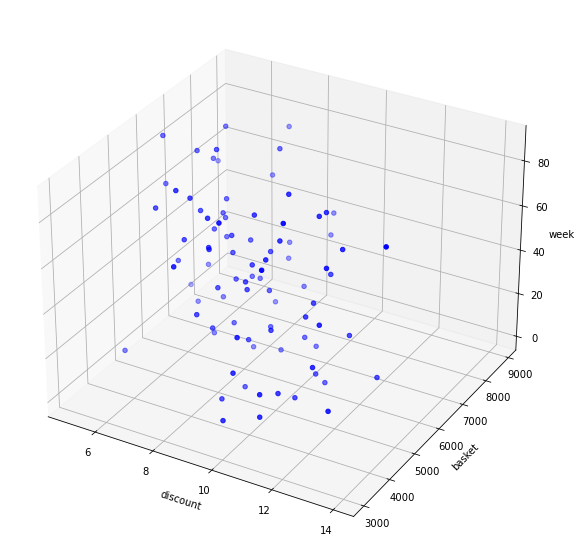

In [26]:
shopper = df_baskets.loc[df_baskets['shopper'] == 30]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(
    shopper['discount_mean'],
    shopper['price_sum'],
    shopper['week'],
    c='b',
    marker='o')
ax.set_xlabel('discount')
ax.set_ylabel('basket')
ax.set_zlabel('week')

plt.show()

In [27]:
# our CUSTOM MODEL
# SET product probability to reorder and identify trend based on last 15, 10, 5, and last week(negative trend)
# SET discount at any rate customer spend much, and compare it to other percentages
# SET product price to the most occured in all weeks, last 15,10,5, and last week then AVG them
# BUILD DF to recognize which products are likly to order then test on baskets week 70-89
# ERRORS product sum if product is recommended to order but not ordered
# ERRORS discount test if the customer spent the most on the same predicted discounts
# BUILD custom df each shopper each product each discount and probability then
# Revenue = (1-discount) * P(discount) * price
# Finally groupby and order the perentages on how likely the most revenue

In [28]:
# helper VARs
last_week = df['week'].max()
weeks_list = [15,10,5,0]
weeks_list = [ last_week-w for w in weeks_list]

In [29]:
# SET product probability to reorder and recognize trend based on last 15, 10, 5, and last week(negative trend)

def product_propability_df(wk):
    product_propability = df.loc[df['week'] <= wk,['shopper','product']] \
        .groupby(['shopper','product'], as_index=True) \
        .apply(np.count_nonzero)
    product_propability.columns = [f'count_{wk}']

    return product_propability

print("\nStarting nproduct_propability\nproduct_propability....\n")
start = time()
product_propability_list = list()
for wk in tqdm(weeks_list):
    product_propability_list.append(product_propability_df(wk))

product_propability = pd.concat(product_propability_list, axis=1).reset_index()
del product_propability_list

print(f"\nproduct_propability took: {timer(start)}")

  0%|          | 0/4 [00:00<?, ?it/s]
Starting nproduct_propability
product_propability....

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

product_propability took: 2


In [30]:
product_propability = product_propability \
    .reset_index(drop=True) \
    .merge(orders_shopper[['shopper','count']], on=['shopper'])
product_propability.rename(columns={'count':'count_orders'}, inplace=True)
# product_propability.isna().sum()
# product_propability.isna()
product_propability
# orders_shopper

# product_weeks

,shopper,product,0,1,2,3,count_orders
0,0,1,2.0,2.0,2.0,2,90
1,0,2,2.0,2.0,2.0,3,90
2,0,3,1.0,1.0,1.0,2,90
3,0,4,11.0,11.0,11.0,11,90
4,0,5,2.0,2.0,2.0,2,90
...,...,...,...,...,...,...,...
11038,49,245,6.0,6.0,6.0,6,90
11039,49,246,8.0,8.0,8.0,8,90
11040,49,247,4.0,4.0,4.0,4,90
11041,49,248,38.0,42.0,42.0,44,90


In [31]:
# SET discount at any rate customer spend much, and compare it to other percentages

def discount_propability_df(wk):
    discount_propability = df.loc[df['week'] <= wk,['shopper','discount', 'price']] \
        .groupby(['shopper','discount'], as_index=True) \
        .agg({'price':np.sum})
    discount_propability.columns = [ f'price_{wk}']

    return discount_propability

print("\nStarting discount_propability\ndiscount_propability....\n")
start = time()
discount_propability_list = list()
for wk in tqdm(weeks_list):
    discount_propability_list.append(discount_propability_df(wk))

discount_propability = pd.concat(discount_propability_list, axis=1).reset_index()
del discount_propability_list

print(f"\ndiscount_propability took: {timer(start)}")

  0%|          | 0/4 [00:00<?, ?it/s]
Starting discount_propability
discount_propability....

100%|██████████| 4/4 [00:00<00:00, 36.39it/s]
discount_propability took: 0



In [32]:
discount_propability.head(20)

,shopper,discount,price_74,price_79,price_84,price_89
0,0,0,374107,397472,420554,440938
1,0,10,0,0,0,0
2,0,15,2631,2631,2631,2631
3,0,20,572,884,1368,1871
4,0,25,847,847,847,1857
5,0,30,666,1095,1095,1510
6,0,35,1144,1144,1144,1482
7,0,40,1059,1059,1059,1441
8,1,0,311928,334319,354506,377461
9,1,10,945,945,945,945


In [33]:
# SET product price to the most occured in all weeks, last 15,10,5, and last week then AVG them

# def mean_most_two(x):
#     return np.mean(x.value_counts().index[0:2])

def product_price_df(wk):
    product_price = price_map.loc[price_map['week'] <= wk ,['product','price']] \
        .groupby(['product'], as_index=True) \
        .agg(lambda x: x.value_counts().index[0])
    product_price.columns = [f'price_{wk}']
    return product_price

print("\nStarting product_price\nproduct_price....\n")
start = time()
product_price_list = list()
for wk in tqdm(weeks_list):
    product_price_list.append(product_price_df(wk))

product_price = pd.concat(product_price_list, axis=1).reset_index()
del product_price_list

product_price['mean'] = np.mean(product_price.iloc[:,1:], axis=1)

print(f"\nproduct_price took: {timer(start)}")

  0%|          | 0/4 [00:00<?, ?it/s]
Starting product_price
product_price....

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]
product_price took: 1



In [34]:
product_price.tail(10)

,product,price_74,price_79,price_84,price_89,mean
240,240,528,528,528,528,528.0
241,241,699,699,699,699,699.0
242,242,511,511,511,511,511.0
243,243,490,490,490,490,490.0
244,244,694,694,694,694,694.0
245,245,549,549,549,549,549.0
246,246,0,0,0,0,0.0
247,247,670,670,670,670,670.0
248,248,490,490,490,490,490.0
249,249,499,499,499,499,499.0
